#neuritesQuantified

##probabilities

In [1]:
import math
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append('Users/drdiek/Dropbox/Python/dir_neuritesQuantified/lib')

In [3]:
print "Initializing variables ..."

nCells = [0, 0, 0, 0, 0, 0]
nLayers = [4, 5, 4, 4, 3, 6]

try:
    overlapBinaryDF = pd.read_csv('data/overlap_matrix.csv')
except IOError:
    print "The file {} does not exist.".format('data/overlap_matrix.csv')
try:
    neuritesQuantifiedDF = pd.read_excel('data/neurites_quantified_v1.0.xlsx')
except IOError:
    print "The file {} does not exist.".format('neurites_quantified_v1.0.xlsx')

nCells[0] = len(overlapBinaryDF.loc[overlapBinaryDF['UniqueIDs'] < 2000])
nCells[1] = len(overlapBinaryDF.loc[overlapBinaryDF['UniqueIDs'] < 3000]) - sum(nCells[0:1])
nCells[2] = len(overlapBinaryDF.loc[overlapBinaryDF['UniqueIDs'] < 4000]) - sum(nCells[0:2])
nCells[3] = len(overlapBinaryDF.loc[overlapBinaryDF['UniqueIDs'] < 5000]) - sum(nCells[0:3])
nCells[4] = len(overlapBinaryDF.loc[overlapBinaryDF['UniqueIDs'] < 6000]) - sum(nCells[0:4])
nCells[5] = len(overlapBinaryDF.loc[overlapBinaryDF['UniqueIDs'] > 5999])

Initializing variables ...


In [4]:
quantityDF = neuritesQuantifiedDF['Density']
selections = [{'string'     : 'Probabilities', \
               'plotString' : 'Probabilities', \
               'selection'  : 6}]            
quantitySelectionsDF = pd.DataFrame(selections)

In [5]:
subregionDF = pd.DataFrame([{'selection' : 0}])

In [6]:
print "Averaging quantity values ..."

neuritesDF = neuritesQuantifiedDF['Unique_ID'].apply(str) + ':' + neuritesQuantifiedDF['Neurite']

uniqueNeurites = neuritesDF.unique()
meansDF = pd.DataFrame([{'Factors'   : 0, \
                         'Means'     : 0, \
                         'Neurites'  : 0, \
                         'UniqueIDs' : 0}])

for i in range(len(uniqueNeurites)):
    idx = neuritesDF.index[neuritesDF == uniqueNeurites[i]]
    meansDF.loc[i, 'Factors'] = len(idx)
    meansDF.loc[i, 'UniqueIDs'] = neuritesQuantifiedDF['Unique_ID'].iloc[idx[0]]
    meansDF.loc[i, 'Neurites'] = neuritesQuantifiedDF['Neurite'].iloc[idx[0]]
    lst = list(quantityDF.iloc[idx])
    meansDF.loc[i, 'Means'] = sum(lst)/float(len(lst))

Averaging quantity values ...


In [8]:
def parcel_lookup(parcel):
    parcels = ('DG:SMo', \
               'DG:SMi', \
               'DG:SG', \
               'DG:H', \
               'CA3:SLM', \
               'CA3:SR', \
               'CA3:SL', \
               'CA3:SP', \
               'CA3:SO', \
               'CA2:SLM', \
               'CA2:SR', \
               'CA2:SP', \
               'CA2:SO', \
               'CA1:SLM', \
               'CA1:SR', \
               'CA1:SP', \
               'CA1:SO', \
               'Sub:SM', \
               'Sub:SP', \
               'Sub:PL', \
               'EC:I', \
               'EC:II', \
               'EC:III', \
               'EC:IV', \
               'EC:V', \
               'EC:VI')
    for i in range(len(parcels)):
        if parcels[i] == parcel:
            parcelNo = i
    return(parcelNo)

In [9]:
overlapBinaryDataDF = overlapBinaryDF.iloc[:,4:]

axonsDF = (overlapBinaryDataDF == 1) | (overlapBinaryDataDF == 3).astype(int)
dendritesDF = (overlapBinaryDataDF == 2) | (overlapBinaryDataDF == 3).astype(int)

nNeurons = len(overlapBinaryDF)
nRows, nColumns = overlapBinaryDF.shape
nParcels = nColumns - 4 # account for header columns (UniqueIDs, NAmes, Abbreviations, EorI)

overlapBinaryProbabilityDF = pd.DataFrame(np.zeros(shape=(nNeurons, nNeurons)))

print "Calculating overlapBinary probabilities ..."
for i in range(nNeurons):
    for j in range(nNeurons):
        overlapBinaryProbabilityDF.iloc[i, j] = (2*(overlapBinaryDF.loc[i, 'EorI'] == 'E')-1) * \
                                                 np.sign(sum(axonsDF.iloc[i, :] & dendritesDF.iloc[j, :]))
overlapBinaryProbabilityDF = overlapBinaryProbabilityDF.astype(int)

axonsDF = dendritesDF = pd.DataFrame(np.zeros(shape=(nNeurons, nParcels)))

for k in range(len(meansDF)):
    i = overlapBinaryDF['UniqueIDs'].index[overlapBinaryDF['UniqueIDs'] == meansDF.loc[k, 'UniqueIDs']]
    neuriteStr = meansDF.loc[k, 'Neurites']
    idx = [pos for pos, char in enumerate(neuriteStr) if char == ':']
    parcel = neuriteStr[:idx[1]]
    j = parcel_lookup(parcel)
    neurite = neuriteStr[idx[1]+1:]
    if neurite == 'A':
        if math.isnan(meansDF.loc[k, 'Means']):
            axonsDF.iloc[i, j] = 0
        else:
            axonsDF.iloc[i, j] = meansDF.loc[k, 'Means']
    else:
        if math.isnan(meansDF.loc[k, 'Means']):
            dendritesDF.iloc[i, j] = 0
        else:
            dendritesDF.iloc[i, j] = meansDF.loc[k, 'Means']

gradedProbabilityDF = pd.DataFrame(np.zeros(shape=(nNeurons, nNeurons)))

print "Calculating graded probabilities ..."
for i in range(nNeurons):
    for j in range(nNeurons):
        axonsLST = list(axonsDF.iloc[i, :])
        dendritesLST = list(dendritesDF.iloc[j, :])
        gradedProbabilityDF.iloc[i, j] = sum([a*b for a,b in zip(axonsLST, dendritesLST)])

Calculating overlapBinary probabilities ...
Calculating graded probabilities ...


In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from lib.diek_functions import time_stamp

from lib.plot_functions import HCcolors as c
from lib.plot_functions import make_color_map

Making probability color map ...
Plotting probability background data ...


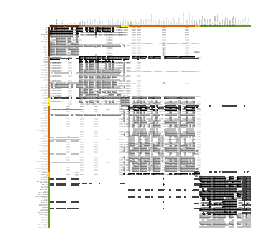

Saving data to pdf file output/probability_matrix_201811271626.pdf ...



In [11]:
nNeurons = len(overlapBinaryDF)

regionColors = [c.BROWN_DG,
                c.BROWN_CA3,
                c.YELLOW_CA2,
                c.ORANGE_CA1,
                c.YELLOW_Sub,
                c.GREEN_EC]
DG = 0
CA3 = 1
CA2 = 2
CA1 = 3
Sub = 4
EC = 5

probabilityColors = [c.GRAY_LIGHT,
                     c.WHITE,
                     c.GRAY_DARK]

nProbabilityColors = len(probabilityColors)

print "Making probability color map ..."
probabilityColorMap = make_color_map(probabilityColors)

print "Plotting probability background data ..."
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_aspect("equal")

ax.axis('off')

plt.pcolormesh(overlapBinaryProbabilityDF.iloc[:,:], cmap=probabilityColorMap)

plt.xlim(-10, nNeurons)
plt.ylim(-10, nNeurons)

plt.gca().invert_yaxis()

displayFontSize = 0.5

# color-coded tags for the subregions
ax.add_patch(patches.Rectangle((sum(nCells[:DG]), -1), nCells[DG], 1, edgecolor="none", facecolor=c.BROWN_DG))
ax.add_patch(patches.Rectangle((sum(nCells[:CA3]), -1), nCells[CA3], 1, edgecolor="none", facecolor=c.BROWN_CA3))
ax.add_patch(patches.Rectangle((sum(nCells[:CA2]), -1), nCells[CA2], 1, edgecolor="none", facecolor=c.YELLOW_CA2))
ax.add_patch(patches.Rectangle((sum(nCells[:CA1]), -1), nCells[CA1], 1, edgecolor="none", facecolor=c.ORANGE_CA1))
ax.add_patch(patches.Rectangle((sum(nCells[:Sub]), -1), nCells[Sub], 1, edgecolor="none", facecolor=c.YELLOW_Sub))
ax.add_patch(patches.Rectangle((sum(nCells[:EC]), -1), nCells[EC], 1, edgecolor="none", facecolor=c.GREEN_EC))

ax.add_patch(patches.Rectangle((-1, sum(nCells[:DG])), 1, nCells[DG], edgecolor="none", facecolor=c.BROWN_DG))
ax.add_patch(patches.Rectangle((-1, sum(nCells[:CA3])), 1, nCells[CA3], edgecolor="none", facecolor=c.BROWN_CA3))
ax.add_patch(patches.Rectangle((-1, sum(nCells[:CA2])), 1, nCells[CA2], edgecolor="none", facecolor=c.YELLOW_CA2))
ax.add_patch(patches.Rectangle((-1, sum(nCells[:CA1])), 1, nCells[CA1], edgecolor="none", facecolor=c.ORANGE_CA1))
ax.add_patch(patches.Rectangle((-1, sum(nCells[:Sub])), 1, nCells[Sub], edgecolor="none", facecolor=c.YELLOW_Sub))
ax.add_patch(patches.Rectangle((-1, sum(nCells[:EC])), 1, nCells[EC], edgecolor="none", facecolor=c.GREEN_EC))

# parcellation subregion headers
tab = [sum(nCells[:DG]) + (nCells[DG]+1)/2,
       sum(nCells[:CA3]) + (nCells[CA3]+1)/2,
       sum(nCells[:CA2]) + (nCells[CA2]+1)/2,
       sum(nCells[:CA1]) + (nCells[CA1]+1)/2,
       sum(nCells[:Sub]) + (nCells[Sub]+1)/2,
       sum(nCells[:EC]) + (nCells[EC]+1)/2
      ]
ax.text(tab[DG], -0.25, "DG", rotation=0, horizontalalignment="center", fontsize=displayFontSize, color=c.WHITE)
ax.text(tab[CA3], -0.25, "CA3", rotation=0, horizontalalignment="center", fontsize=displayFontSize, color=c.WHITE)
ax.text(tab[CA2], -0.25, "CA2", rotation=0, horizontalalignment="center", fontsize=displayFontSize, color=c.BLACK)
ax.text(tab[CA1], -0.25, "CA1", rotation=0, horizontalalignment="center", fontsize=displayFontSize, color=c.WHITE)
ax.text(tab[Sub], -0.25, "Sub", rotation=0, horizontalalignment="center", fontsize=displayFontSize, color=c.BLACK)
ax.text(tab[EC], -0.25, "EC", rotation=0, horizontalalignment="center", fontsize=displayFontSize, color=c.WHITE)

ax.text(-0.5, tab[DG], "DG", rotation=90, verticalalignment="bottom", horizontalalignment="center",
        fontsize=displayFontSize, color=c.WHITE)
ax.text(-0.5, tab[CA3], "CA3", rotation=90, verticalalignment="bottom", horizontalalignment="center",
        fontsize=displayFontSize, color=c.WHITE)
ax.text(-0.5, tab[CA2], "CA2", rotation=90, verticalalignment="bottom", horizontalalignment="center",
        fontsize=displayFontSize, color=c.BLACK)
ax.text(-0.5, tab[CA1], "CA1", rotation=90, verticalalignment="bottom", horizontalalignment="center",
        fontsize=displayFontSize, color=c.WHITE)
ax.text(-0.5, tab[Sub], "Sub", rotation=90, verticalalignment="bottom", horizontalalignment="center",
        fontsize=displayFontSize, color=c.BLACK)
ax.text(-0.5, tab[EC], "EC", rotation=90, verticalalignment="bottom", horizontalalignment="center",
        fontsize=displayFontSize, color=c.WHITE)

for i in range(nNeurons):
    textColor = c.BLACK
    if overlapBinaryDF.loc[i, 'EorI'] == 'I':
        textColor = c.GRAY
    ax.text(i+0.5, -1.25, overlapBinaryDF.loc[i, 'Abbreviations'], rotation=90, horizontalalignment="center",
            verticalalignment="bottom", fontsize=displayFontSize, color=textColor)
    ax.text(-1.25, i+0.5, overlapBinaryDF.loc[i, 'Abbreviations'], rotation=0, horizontalalignment="right",
            verticalalignment="center", fontsize=displayFontSize, color=textColor)

for i in range(nNeurons):
    for j in range(nNeurons):
        if gradedProbabilityDF.iloc[i, j] > 0:
            strng = '{:.2e}'.format(gradedProbabilityDF.iloc[i, j])
            if overlapBinaryProbabilityDF.iloc[i, j] == 0:
                textColor = c.BLACK
                if overlapBinaryDF.loc[i, 'EorI'] == 'I':
                    textColor = c.GRAY
                ax.text(j+1.5, i+0.5, strng, rotation=0, horizontalalignment="center", fontsize=displayFontSize/2,
                        color=textColor)
            else:
                faceColor = c.BLACK
                if overlapBinaryDF.loc[i, 'EorI'] == 'I':
                    faceColor = c.GRAY
                ax.add_patch(patches.Rectangle((j, i), # (x,y)
                                               1,             # width
                                               1,             # height
                                               edgecolor="none",
                                               facecolor=faceColor
                                              )
                            )
                ax.text(j+1.5, i+0.5, strng, rotation=0, horizontalalignment="center", fontsize=displayFontSize/2,
                        color=c.WHITE)

plt.show()

# save plot
outputFileName = "output/probability_matrix_%s.pdf" % time_stamp()
print "Saving data to pdf file %s ...\n" % outputFileName    
fig.savefig(outputFileName, dpi=600)